In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
import pickle

import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import torch_geometric
from torchsummary import summary
import torch_scatter

from rdkit import Chem
from rdkit.Chem import Descriptors, rdmolops

from sklearn.model_selection import train_test_split

# Load data
with open('filtered_labels.pkl', 'rb') as f:
    filtered_labels = pickle.load(f)
with open('filtered_mol_ls.pkl', 'rb') as f:
    filtered_mol_ls = pickle.load(f)

In [21]:

pt.GetAtomicWeight(1)

1.008

In [22]:
pt.GetNOuterElecs(15)

5

In [23]:
def normalize_bw_neg1and1(dictionary: dict):
    values = list(dictionary.values())
    for k, v in dictionary.items():
        dictionary[k] = 2*(v - min(values))/(max(values) - min(values)) - 1
    return dictionary



{1: -0.9888268156424579,
 6: -0.5977653631284918,
 7: -0.05027932960893844,
 8: 0.3966480446927374,
 9: 1.0,
 15: -1.0,
 16: -0.5642458100558658,
 17: 0.08379888268156455,
 35: -0.13966480446927376,
 53: -0.4748603351955305}

In [29]:
covalent_radii = {i: pt.GetRcovalent(i) for i in allowed_atoms}

In [32]:
order_string = {
            Chem.rdchem.BondType.SINGLE: np.array([1, 0, 0, 0]),
            Chem.rdchem.BondType.DOUBLE: np.array([0, 1, 0, 0]),
            Chem.rdchem.BondType.TRIPLE: np.array([0, 0, 1, 0]),
            Chem.rdchem.BondType.AROMATIC: np.array([0, 0, 0, 1]),
}

pt = Chem.GetPeriodicTable()

allowed_atoms = [1, 6, 7, 8, 9, 15, 16, 17, 35, 53] #H, C, N, O, F, P, S, Cl, Br, I
atoms_one_hot_key = np.eye(len(allowed_atoms))

electronegativities = {
    1: 2.2,
    6: 2.55,
    7: 3.04,
    8: 3.44,
    9: 3.98,
    15: 2.19,
    16: 2.58,
    17: 3.16,
    35: 2.96,
    53: 2.66
}

ionization_energies = {
    1: 13.6,
    6: 11.3,
    7: 14.5,
    8: 13.6,
    9: 17.4,
    15: 10.5,
    16: 10.4,
    17: 13.0,
    35: 11.8,
    53: 10.45
}

valence_electrons = {
    1:  1,
    6:  4,
    7:  5,
    8:  6,
    9:  7,
    15: 5,
    16: 6,
    17: 7,
    35: 7,
    53: 7
}

covalent_radii = {i: pt.GetRcovalent(i) for i in allowed_atoms}
atomic_mass = {i: pt.GetAtomicWeight(i) for i in allowed_atoms}

def normalize_bw_neg1and1(dictionary: dict):
    values = list(dictionary.values())
    for k, v in dictionary.items():
        dictionary[k] = 2*(v - min(values))/(max(values) - min(values)) - 1
    return dictionary

electronegativities = normalize_bw_neg1and1(electronegativities)
ionization_energies = normalize_bw_neg1and1(ionization_energies)
valence_electrons = normalize_bw_neg1and1(valence_electrons)
covalent_radii = normalize_bw_neg1and1(covalent_radii)
atomic_mass = normalize_bw_neg1and1(atomic_mass)

def get_features(ligand, label):
    #Get a list of atomic numbers for each ligand
    atoms_one_hot = np.stack([atoms_one_hot_key[allowed_atoms.index(a.GetAtomicNum())] for a in ligand.GetAtoms()])
    other_atom_features = [[electronegativities[a.GetAtomicNum()],
                            ionization_energies[a.GetAtomicNum()],
                            valence_electrons[a.GetAtomicNum()],
                            covalent_radii[a.GetAtomicNum()],
                            atomic_mass[a.GetAtomicNum()]] for a in ligand.GetAtoms()]
    atom_features = np.hstack((atoms_one_hot, np.array(other_atom_features)))
    
    
    #Get the number of atoms for each ligand
    natoms = len(ligand.GetAtoms())
    
    #Get the adjacency matrix for each ligand
    adj = rdmolops.GetAdjacencyMatrix(ligand)
    
    #Get the edge index list in COO format for each ligand
    edge_index = (adj>0).nonzero()
    
    #Get the edge features (one-hot encoding of the bond type
    feats = np.zeros((4, len(edge_index[0])))
    for i in range(len(edge_index[0])):
        feats[:, i] = order_string[ligand.GetBondBetweenAtoms(int(edge_index[0][i]), int(edge_index[1][i])).GetBondType()]
    edge_feats = feats.T

    #Get the probability of each atom being a connecting atom (0 or 1)
    y = np.zeros(natoms)
    y[np.array(label)] = 1

    return atom_features, natoms, edge_index, edge_feats, y

atom_features_list = []
natom_list = []
edge_index_list = []
edge_feats_list = []
y_list = []
num_failed = 0

for idx in tqdm(range(len(filtered_mol_ls))):
    ligand = filtered_mol_ls[idx]
    label = filtered_labels[idx]
    try:
        atom_features, natoms, edge_index, edge_feats, y = get_features(ligand, label)
        atom_features_list.append(atom_features)
        natom_list.append(natoms)
        edge_index_list.append(edge_index)
        edge_feats_list.append(edge_feats)
        y_list.append(y)
    except:
        num_failed += 1

len(atom_features_list), num_failed

100%|██████████| 42026/42026 [00:11<00:00, 3535.01it/s]


(41996, 30)

In [33]:
# train/test
(train_atom_list, test_atom_list,
 train_natom_list, test_natom_list,
 train_edge_index_list, test_edge_index_list,
 train_edge_feats_list, test_edge_feats_list,
 train_y_list, test_y_list) = train_test_split(atom_features_list,
                                               natom_list,
                                               edge_index_list,
                                               edge_feats_list,
                                               y_list,
                                               test_size=0.1, shuffle=True)
# split train further into train + val
(train_atom_list, val_atom_list,
 train_natom_list, val_natom_list,
 train_edge_index_list, val_edge_index_list,
 train_edge_feats_list, val_edge_feats_list,
 train_y_list, val_y_list) = train_test_split(train_atom_list,
                                              train_natom_list,
                                              train_edge_index_list,
                                              train_edge_feats_list,
                                              train_y_list,
                                              test_size=1/9, shuffle=True)

In [34]:
class LigandDataset():
    def __init__(self, atom_list, natom_list, edge_index_list, edge_feats_list, y_list):
        self.atom_list = atom_list
        self.natom_list = natom_list
        self.edge_index_list = edge_index_list
        self.edge_feats_list = edge_feats_list
        self.y_list = y_list
        
    def __len__(self):
        return len(self.atom_list)
        
    def __getitem__(self, idx):
        return Data(x=torch.Tensor(self.atom_list[idx]),
                    natoms=torch.Tensor([self.natom_list[idx]]),
                    edge_index=torch.Tensor(np.array(self.edge_index_list[idx])),
                    edge_attr=torch.Tensor(self.edge_feats_list[idx]),
                    # y=torch.Tensor(self.y_list[idx]).to(torch.long)
                    y=torch.nn.functional.one_hot(torch.Tensor(self.y_list[idx]).to(torch.long), num_classes=2) # one-hot
                   )

train_data = LigandDataset(train_atom_list, train_natom_list, train_edge_index_list, train_edge_feats_list, train_y_list)
test_data = LigandDataset(test_atom_list, test_natom_list, test_edge_index_list, test_edge_feats_list, test_y_list)
val_data = LigandDataset(val_atom_list, val_natom_list, val_edge_index_list, val_edge_feats_list, val_y_list)

In [35]:
train_loader = DataLoader(train_data, batch_size=100, shuffle=True)
val_loader = DataLoader(val_data, batch_size=100, shuffle=True)
test_loader = DataLoader(test_data, batch_size=100, shuffle=False)

In [36]:
def compute_batch_loss(inputs, labels, inds):
    """ Computes batch loss by separating out the losses for each ligand. """
    graph_sizes = torch.tensor([(inds[i+1] - inds[i]) for i in range(len(inds)-1)], device=inputs.device)
    segment_ids = torch.repeat_interleave(torch.arange(len(graph_sizes), device=inputs.device), graph_sizes)
    loss_per_node = torch.nn.functional.binary_cross_entropy_with_logits(inputs, labels, reduction='none')
    graph_losses = torch_scatter.scatter_mean(loss_per_node, segment_ids, dim=0)
    return graph_losses.mean()

In [37]:
gat = torch_geometric.nn.GAT(-1, 5, num_layers=3, out_channels=2, dropout=0.3)
optimizer = torch.optim.Adam(gat.parameters(), lr=1e-3)

num_epochs = 20
gat.to(0)

train_epoch_losses = []
val_epoch_losses = []

for epoch in range(num_epochs):
    epoch_train_loss = 0
    gat.train()
    for i, batch in enumerate(train_loader):
        batch.to(0)

        out_probs = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        loss = compute_batch_loss(out_probs, batch.y.to(torch.float64), batch.ptr)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss = epoch_train_loss / (i+1)
    train_epoch_losses.append(epoch_train_loss)
    
    epoch_val_loss = 0
    gat.eval()
    with torch.no_grad():
        for i, batch in enumerate(val_loader):
            batch.to(0)
            out_probs = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
            loss = compute_batch_loss(out_probs, batch.y.to(torch.float64), batch.ptr)
            epoch_val_loss += loss.item()
    epoch_val_loss = epoch_val_loss / (i+1)
    val_epoch_losses.append(epoch_val_loss)
    
    print(f'Epoch: {epoch+1} | Avg Train Loss: {epoch_train_loss:.3} | Avg Val Loss: {epoch_val_loss:.3}')

Epoch: 1 | Avg Train Loss: 0.487 | Avg Val Loss: 0.377
Epoch: 2 | Avg Train Loss: 0.405 | Avg Val Loss: 0.354
Epoch: 3 | Avg Train Loss: 0.389 | Avg Val Loss: 0.352
Epoch: 4 | Avg Train Loss: 0.382 | Avg Val Loss: 0.352
Epoch: 5 | Avg Train Loss: 0.378 | Avg Val Loss: 0.352
Epoch: 6 | Avg Train Loss: 0.375 | Avg Val Loss: 0.352
Epoch: 7 | Avg Train Loss: 0.372 | Avg Val Loss: 0.352
Epoch: 8 | Avg Train Loss: 0.369 | Avg Val Loss: 0.346
Epoch: 9 | Avg Train Loss: 0.363 | Avg Val Loss: 0.339
Epoch: 10 | Avg Train Loss: 0.36 | Avg Val Loss: 0.336
Epoch: 11 | Avg Train Loss: 0.358 | Avg Val Loss: 0.334
Epoch: 12 | Avg Train Loss: 0.358 | Avg Val Loss: 0.334
Epoch: 13 | Avg Train Loss: 0.355 | Avg Val Loss: 0.33
Epoch: 14 | Avg Train Loss: 0.355 | Avg Val Loss: 0.329
Epoch: 15 | Avg Train Loss: 0.355 | Avg Val Loss: 0.329
Epoch: 16 | Avg Train Loss: 0.355 | Avg Val Loss: 0.33
Epoch: 17 | Avg Train Loss: 0.355 | Avg Val Loss: 0.33
Epoch: 18 | Avg Train Loss: 0.355 | Avg Val Loss: 0.33
Epoch:

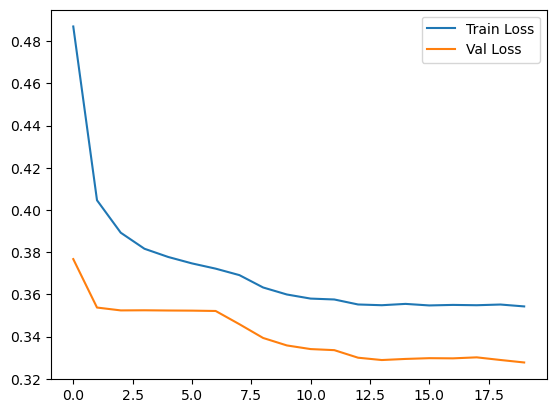

In [38]:
plt.plot(range(num_epochs), train_epoch_losses, label='Train Loss')
plt.plot(range(num_epochs), val_epoch_losses, label='Val Loss')
plt.legend()

In [39]:
gat.eval()
test_loss = 0
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        batch.to(0)
        out_probs = gat(x=batch.x, edge_index=batch.edge_index.to(torch.int64), edge_attr=batch.edge_attr)
        loss = compute_batch_loss(out_probs, batch.y.to(torch.float64), batch.ptr)
        test_loss += loss.item()
    test_loss /= (i+1)
print(f'Test Loss: {test_loss}')

Test Loss: 0.32769757766442414


In [94]:
summary(gat)

Layer (type:depth-idx)                   Param #
├─ReLU: 1-1                              --
├─ModuleList: 1-2                        --
|    └─GATConv: 2-1                      --
|    |    └─SumAggregation: 3-1          --
|    |    └─Linear: 3-2                  20
|    └─GATConv: 2-2                      --
|    |    └─SumAggregation: 3-3          --
|    |    └─Linear: 3-4                  4
Total params: 24
Trainable params: 24
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─ReLU: 1-1                              --
├─ModuleList: 1-2                        --
|    └─GATConv: 2-1                      --
|    |    └─SumAggregation: 3-1          --
|    |    └─Linear: 3-2                  20
|    └─GATConv: 2-2                      --
|    |    └─SumAggregation: 3-3          --
|    |    └─Linear: 3-4                  4
Total params: 24
Trainable params: 24
Non-trainable params: 0